# Crime Data Analysis and Bayesian Network Modeling


## 1. Imports and Setup


### Imports and Setup

- **pandas**: For data manipulation and analysis.
- **numpy**: For numerical operations.
- **matplotlib and seaborn**: For visualization.
- **sklearn**: For machine learning models and preprocessing.
- **pgmpy**: For building and analyzing Bayesian networks.
- **shap and lime**: For model explainability (although not used explicitly in the code).

will add the imports at the beginning of the script to ensure all dependencies are loaded before executing any logic.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.estimators import HillClimbSearch, BicScore, BayesianEstimator, K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination
import networkx as nx


## 2. Loading and Preprocessing Crime Data

### Loading and Preprocessing Crime Data

- **Loading Crime Data**: load the dataset containing crime data from a specified CSV file.
- **Date Conversion**: The 'Month' column is converted to datetime format for easier filtering and manipulation.
- **Filtering Data**: The data is filtered to retain only records from the year 2021 and those related to the "Violence and sexual offences" crime type.


In [2]:
# Load the dataset containing crime data
crime_data_path = "/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/UK_Police_Street_Crime_2018-10-01_to_2021_09_31.csv"
crime_df = pd.read_csv(crime_data_path)

# Convert 'Month' to datetime and filter for 2021 and specific crime type
crime_df['Month'] = pd.to_datetime(crime_df['Month'])
filtered_crime_df = crime_df[(crime_df['Month'].dt.year == 2021) &
                             (crime_df['Crime type'] == "Violence and sexual offences")]


## 3. Data Cleaning and Aggregation


### Data Cleaning and Aggregation

- **Modifying 'LSOA name'**: modify the 'LSOA name' column to remove the last 5 characters, which might represent redundant information.
- **Renaming Columns**: The 'LSOA name' column is renamed to 'lower_tier_local_authorities' for clarity.
- **Aggregating Data**: The data is aggregated by 'Month' and 'lower_tier_local_authorities', and count the occurrences of crimes within each group.


In [3]:
# Modify 'LSOA name' to remove the last 5 characters
filtered_crime_df['LSOA name'] = filtered_crime_df['LSOA name'].str[:-5]

# Rename 'LSOA name' to 'lower_tier_local_authorities'
filtered_crime_df.rename(columns={'LSOA name': 'lower_tier_local_authorities'}, inplace=True)

# Aggregate the data by 'Month' and 'lower_tier_local_authorities' and count occurrences
aggregated_crime_data = filtered_crime_df.groupby(['Month', 'lower_tier_local_authorities']).size().reset_index(name='crime_count')


/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_45645/2445703618.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crime_df['LSOA name'] = filtered_crime_df['LSOA name'].str[:-5]
/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_45645/2445703618.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_crime_df.rename(columns={'LSOA name': 'lower_tier_local_authorities'}, inplace=True)


## 4. Loading and Merging Socioeconomic Data


### Loading and Merging Socioeconomic Data

- **Loading Socioeconomic Datasets**: load multiple CSV files containing different socioeconomic data such as ethnic groups, economy status, employment history, education level, and migrant data.
- **Renaming Columns**: In each dataset, the locality code columns are renamed to 'area_code' for consistency.
- **Merging Datasets**: All the socioeconomic datasets are merged into a single DataFrame based on the 'area_code' column.


In [4]:
# Load datasets
ethnic_data = pd.read_csv("/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Ethnic_Group_Data_Transformed.csv")
economy_status_data = pd.read_csv("/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Economy_Status_Data_Transformed.csv")
employment_history_data = pd.read_csv("/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Employment_History_Data_Transformed.csv")
education_level_data = pd.read_csv("/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Education_Level_Data_Transformed.csv")
migrant_data = pd.read_csv("/Users/arkamandol/DataspellProjects/Desertation_arka_23023023/data_files/Migrant_Data_Transformed.csv")

# Rename the locality code columns to 'area_code'
ethnic_data.rename(columns={'ethnic_lower_tier_local_authorities_code': 'area_code'}, inplace=True)
economy_status_data.rename(columns={'economy_lower_tier_local_authorities_code': 'area_code'}, inplace=True)
employment_history_data.rename(columns={'employment_lower_tier_local_authorities_code': 'area_code'}, inplace=True)
education_level_data.rename(columns={'education_lower_tier_local_authorities_code': 'area_code'}, inplace=True)
migrant_data.rename(columns={'migrant_lower_tier_local_authorities_code': 'area_code'}, inplace=True)

# Merge all datasets on the 'area_code' column
merged_data = ethnic_data.merge(economy_status_data, on='area_code', how='outer')
merged_data = merged_data.merge(employment_history_data, on='area_code', how='outer')
merged_data = merged_data.merge(education_level_data, on='area_code', how='outer')
merged_data = merged_data.merge(migrant_data, on='area_code', how='outer')


## 5. Cleaning and Merging Final Dataset


### Cleaning and Merging Final Dataset

- **Dropping Redundant Columns**: identify and drop any redundant 'lower_tier_local_authorities' columns from the merged dataset.
- **Final Merging**: The cleaned socioeconomic data is merged with the aggregated crime data using the 'lower_tier_local_authorities' column.
- **Initial Data Inspection**: inspect the first few rows and the structure of the final merged dataset to ensure correctness.


In [5]:
# Load the additional dataset
additional_df = merged_data.copy()

# Identify and drop redundant 'lower_tier_local_authorities' columns
columns_to_drop = [col for col in additional_df.columns if 'lower_tier_local_authorities' in col]
columns_to_drop.remove('ethnic_lower_tier_local_authorities')  # Keep one relevant column

# Drop the identified columns
df_cleaned = additional_df.drop(columns=columns_to_drop)

# Rename the relevant column to 'lower_tier_local_authorities'
df_cleaned.rename(columns={'ethnic_lower_tier_local_authorities': 'lower_tier_local_authorities'}, inplace=True)

# Merge the crime data with the cleaned dataset on 'lower_tier_local_authorities'
merged_data = aggregated_crime_data.merge(df_cleaned, on='lower_tier_local_authorities', how='inner')

# Display basic information and initial rows of the merged dataset
print(merged_data.head())
print(merged_data.info())


       Month lower_tier_local_authorities  crime_count  area_code  \
0 2021-01-01                         Adur           95  E07000223   
1 2021-01-01                    Allerdale          212  E07000026   
2 2021-01-01                 Amber Valley          250  E07000032   
3 2021-01-01                         Arun          316  E07000224   
4 2021-01-01                     Ashfield          272  E07000170   

   ethnic_asian_asian_british_or_asian_welsh_bangladeshi  \
0                                                369       
1                                                 43       
2                                                 37       
3                                                523       
4                                                 56       

   ethnic_asian_asian_british_or_asian_welsh_chinese  \
0                                                269   
1                                                139   
2                                                282   


## 6. Data Preparation for Analysis


### Data Preparation for Analysis

- **Dropping Unnecessary Columns**: drop columns that are not needed for further analysis, like 'lower_tier_local_authorities' and 'area_code'.
- **Renaming Columns**: rename certain columns to shorter, more intuitive names for easier reference.


In [6]:
# Create a copy for processing
data = merged_data.copy()

# Drop columns not needed for analysis
data.drop(columns=['lower_tier_local_authorities', 'area_code'], inplace=True)

# Mapping new column names for easier reference
new_column_names = {
    'ethnic_asian_asian_british_or_asian_welsh_bangladeshi': 'Ethnic_Asian_Bangladeshi',
    'ethnic_asian_asian_british_or_asian_welsh_chinese': 'Ethnic_Asian_Chinese',
    'ethnic_asian_asian_british_or_asian_welsh_indian': 'Ethnic_Asian_Indian',
    'ethnic_asian_asian_british_or_asian_welsh_other_asian': 'Ethnic_Asian_Other',
    'ethnic_asian_asian_british_or_asian_welsh_pakistani': 'Ethnic_Asian_Pakistani',
    'ethnic_black_black_british_black_welsh_caribbean_or_african_african': 'Ethnic_Black_African',
    'ethnic_black_black_british_black_welsh_caribbean_or_african_caribbean': 'Ethnic_Black_Caribbean',
    'ethnic_black_black_british_black_welsh_caribbean_or_african_other_black': 'Ethnic_Black_Other',
    'ethnic_mixed_or_multiple_ethnic_groups_other_mixed_or_multiple_ethnic_groups': 'Ethnic_Mixed_Other',
    'ethnic_mixed_or_multiple_ethnic_groups_white_and_asian': 'Ethnic_Mixed_White_Asian',
    'ethnic_mixed_or_multiple_ethnic_groups_white_and_black_african': 'Ethnic_Mixed_White_Black_African',
    'ethnic_mixed_or_multiple_ethnic_groups_white_and_black_caribbean': 'Ethnic_Mixed_White_Black_Caribbean',
    'ethnic_other_ethnic_group_any_other_ethnic_group': 'Ethnic_Other',
    'ethnic_other_ethnic_group_arab': 'Ethnic_Arab',
    'ethnic_white_english_welsh_scottish_northern_irish_or_british': 'Ethnic_White_British',
    'ethnic_white_gypsy_or_irish_traveller': 'Ethnic_White_Gypsy_Traveller',
    'ethnic_white_irish': 'Ethnic_White_Irish',
    'ethnic_white_other_white': 'Ethnic_White_Other',
    'ethnic_white_roma': 'Ethnic_White_Roma',
    'economy_employed': 'Economy_Employed',
    'economy_not_employed': 'Economy_Not_Employed',
    'employment_not_in_employment_never_worked': 'Employment_Never_Worked',
    'employment_not_in_employment_not_worked_in_the_last_12_months': 'Employment_Not_Worked_12M',
    'employment_not_in_employment_worked_in_the_last_12_months': 'Employment_Worked_12M',
    'education_level_1_and_entry_level_qualifications_1_to_4_gcses_grade_a*_to_c_any_gcses_at_other_grades_o_levels_or_cses_any_grades_1_as_level_nvq_level_1_foundation_gnvq_basic_or_essential_skills': 'Education_Level_1',
    'education_level_2_qualifications_5_or_more_gcses_a*_to_c_or_9_to_4_o_levels_passes_cses_grade_1_school_certification_1_a_level_2_to_3_as_levels_vces_intermediate_or_higher_diploma_welsh_baccalaureate_intermediate_diploma_nvq_level_2_intermediate_gnvq_city_and_guilds_craft_btec_first_or_general_diploma_rsa_diploma': 'Education_Level_2',
    'education_level_3_qualifications_2_or_more_a_levels_or_vces_4_or_more_as_levels_higher_school_certificate_progression_or_advanced_diploma_welsh_baccalaureate_advance_diploma_nvq_level_3;_advanced_gnvq_city_and_guilds_advanced_craft_onc_ond_btec_national_rsa_advanced_diploma': 'Education_Level_3',
    'education_level_4_qualifications_or_above_degree_ba_bsc_higher_degree_ma_phd_pgce_nvq_level_4_to_5_hnc_hnd_rsa_higher_diploma_btec_higher_level_professional_qualifications_for_example_teaching_nursing_accountancy': 'Education_Level_4+',
    'education_no_qualifications': 'Education_No_Qualifications',
    'education_other_apprenticeships_vocational_or_work-related_qualifications_other_qualifications_achieved_in_england_or_wales_qualifications_achieved_outside_england_or_wales_equivalent_not_stated_or_unknown': 'Education_Other_Qualifications',
    'migrant_address_one_year_ago_is_student_term-time_or_boarding_school_address_in_the_uk': 'Migrant_Student_UK',
    'migrant_address_one_year_ago_is_the_same_as_the_address_of_enumeration': 'Migrant_Same_Address',
    'migrant_does_not_apply': 'Migrant_NA',
    'migrant_migrant_from_outside_the_uk_address_one_year_ago_was_outside_the_uk': 'Migrant_Outside_UK',
    'migrant_migrant_from_within_the_uk_address_one_year_ago_was_in_the_uk': 'Migrant_Within_UK'
}

# Rename columns according to the mapping
data.rename(columns=new_column_names, inplace=True)


## 7. Correlation Analysis and Visualization


### Correlation Analysis and Visualization

- **Correlation Matrix Calculation**: calculate the correlation matrix for the dataset to identify relationships between variables.
- **Heatmap Visualization**: A heatmap is plotted to visualize the correlation matrix, making it easier to spot strong correlations.


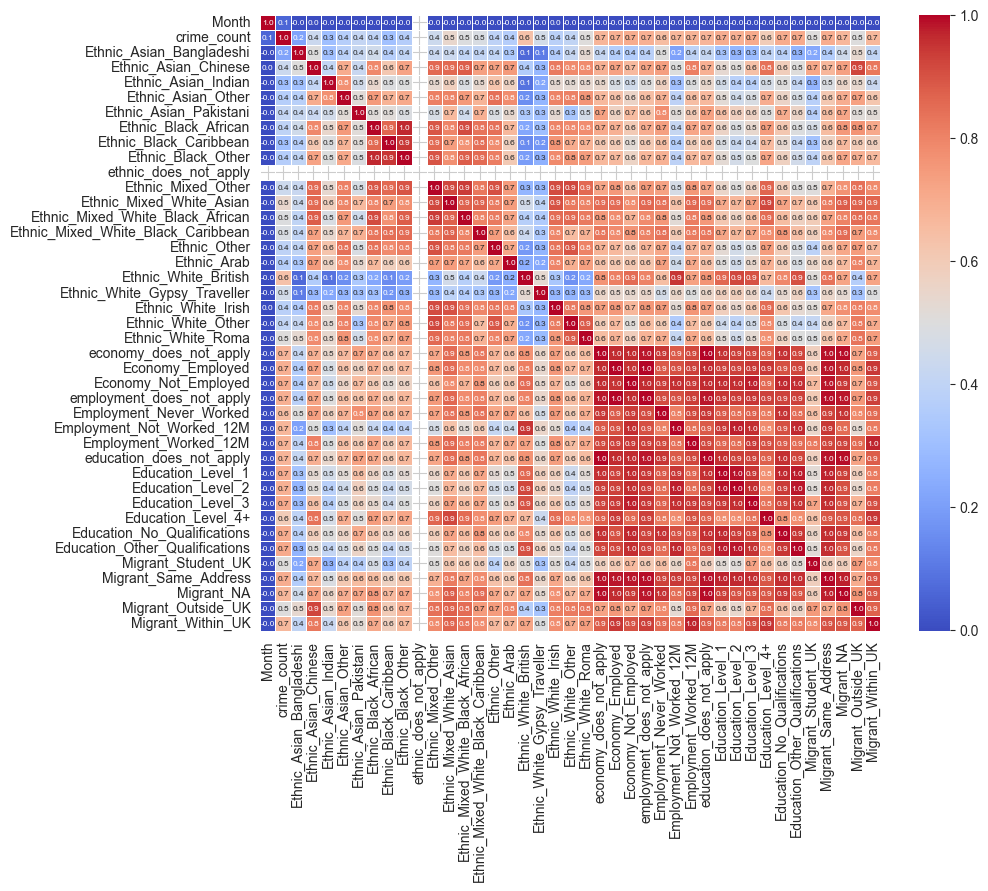

In [7]:
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Set the size of the plot
plt.figure(figsize=(10, 8))  # Increase the figure size for better readability

# Create the heatmap with annotations
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".1f", annot_kws={'size': 6}, cmap='coolwarm', linewidths=.5)

# Rotate the x and y labels for better readability
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.yticks(rotation=0)   # y-axis labels can be left horizontal or adjusted as needed

# Show the plot
plt.show()


## 8. Distribution Analysis


### Distribution Analysis

- **Variable Selection**: select key variables related to crime, education, migration, employment, economy, and ethnicity for further analysis.
- **Distribution Plots**: plot the distribution of these variables using histograms with kernel density estimation (KDE) to understand their underlying distribution.


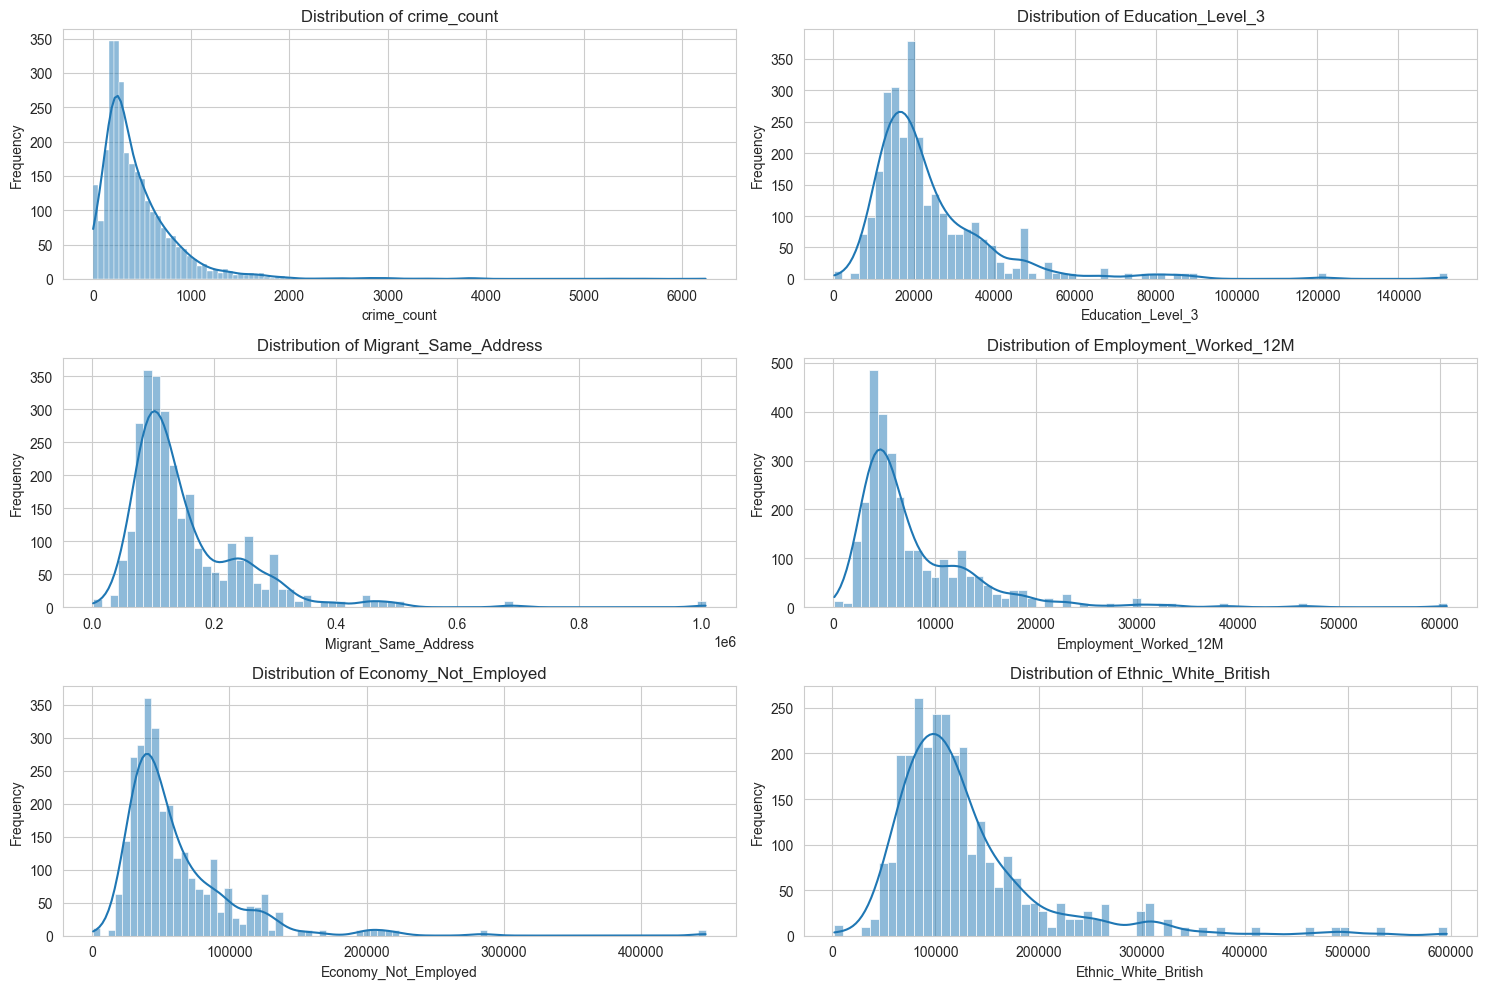

In [8]:
# List of key variables
variables = ['crime_count', 'Education_Level_3', 'Migrant_Same_Address',
             'Employment_Worked_12M', 'Economy_Not_Employed', 'Ethnic_White_British']

# Plotting the distributions
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## 9. Logarithmic Transformation


### Logarithmic Transformation

- **Log Transformation**: apply a logarithmic transformation to the selected variables to normalize their distribution and reduce skewness. This is particularly useful when variables have outliers or are highly skewed.
- **Log-Transformed Distribution Plots**: plot the distributions of the log-transformed variables to compare them with the original distributions.


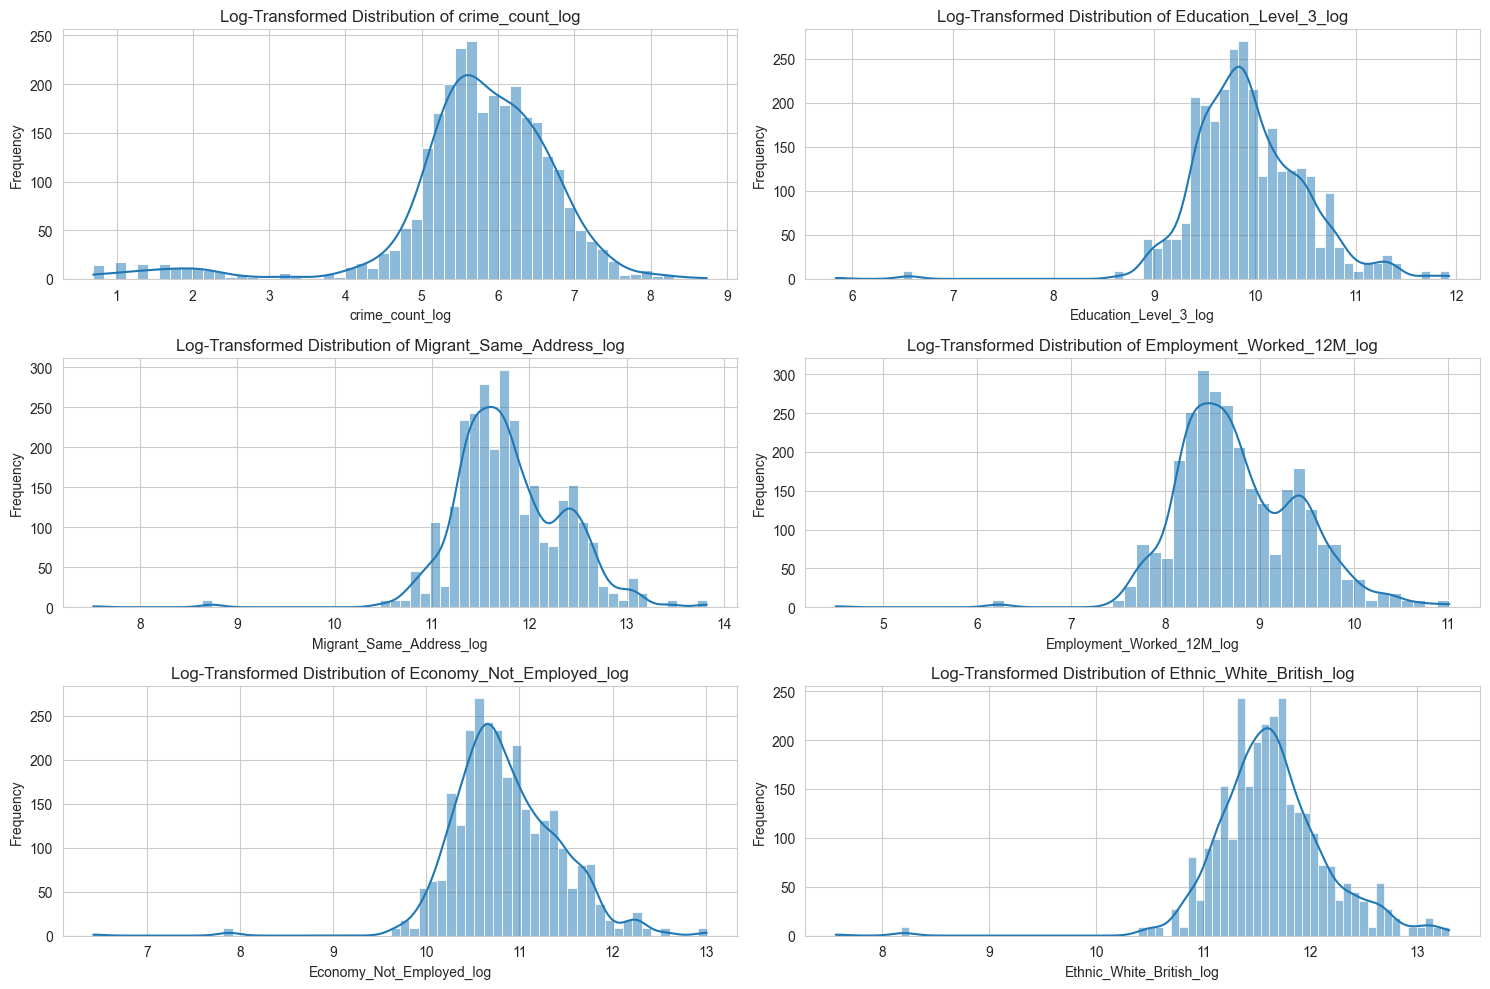

In [9]:
# Applying logarithmic transformation, adding 1 to avoid log(0) issue
log_transformed_data = data.copy()
log_transformed_data['crime_count_log'] = np.log1p(log_transformed_data['crime_count'])
log_transformed_data['Education_Level_3_log'] = np.log1p(log_transformed_data['Education_Level_3'])
log_transformed_data['Migrant_Same_Address_log'] = np.log1p(log_transformed_data['Migrant_Same_Address'])
log_transformed_data['Employment_Worked_12M_log'] = np.log1p(log_transformed_data['Employment_Worked_12M'])
log_transformed_data['Economy_Not_Employed_log'] = np.log1p(log_transformed_data['Economy_Not_Employed'])
log_transformed_data['Ethnic_White_British_log'] = np.log1p(log_transformed_data['Ethnic_White_British'])

# Plotting the log-transformed distributions
plt.figure(figsize=(15, 10))
for i, var in enumerate(['crime_count_log', 'Education_Level_3_log', 'Migrant_Same_Address_log',
                         'Employment_Worked_12M_log', 'Economy_Not_Employed_log', 'Ethnic_White_British_log'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(log_transformed_data[var], kde=True)
    plt.title(f'Log-Transformed Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## 10. Quantile Binning


### Quantile Binning

- **Quantile Binning**: The log-transformed variables are further processed using quantile binning to categorize them into discrete categories (e.g., 'Low', 'Medium', 'High').
- **Binned Data**: The binned data provides a simplified view of the variables, making it easier to analyze and interpret their relationships.


In [10]:
# Applying quantile binning on log-transformed variables
log_binned_data = log_transformed_data.copy()

# Defining the number of bins (e.g., 3 bins for low, medium, high)
n_bins = 3

# Applying quantile binning
log_binned_data['crime_count_binned'] = pd.qcut(log_binned_data['crime_count_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Education_Level_3_binned'] = pd.qcut(log_binned_data['Education_Level_3_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Migrant_Same_Address_binned'] = pd.qcut(log_binned_data['Migrant_Same_Address_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Employment_Worked_12M_binned'] = pd.qcut(log_binned_data['Employment_Worked_12M_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Economy_Not_Employed_binned'] = pd.qcut(log_binned_data['Economy_Not_Employed_log'], q=n_bins, labels=['Low', 'Medium', 'High'])
log_binned_data['Ethnic_White_British_binned'] = pd.qcut(log_binned_data['Ethnic_White_British_log'], q=n_bins, labels=['Low', 'Medium', 'High'])

# Display the first few rows of the binned data
print(log_binned_data[['crime_count_binned', 'Education_Level_3_binned', 'Migrant_Same_Address_binned',
                       'Employment_Worked_12M_binned', 'Economy_Not_Employed_binned', 'Ethnic_White_British_binned']].head())


  crime_count_binned Education_Level_3_binned Migrant_Same_Address_binned  \
0                Low                      Low                         Low   
1                Low                      Low                         Low   
2             Medium                   Medium                      Medium   
3             Medium                   Medium                      Medium   
4             Medium                   Medium                      Medium   

  Employment_Worked_12M_binned Economy_Not_Employed_binned  \
0                          Low                         Low   
1                          Low                         Low   
2                          Low                      Medium   
3                       Medium                        High   
4                          Low                      Medium   

  Ethnic_White_British_binned  
0                         Low  
1                      Medium  
2                      Medium  
3                        High  
4   

## 11. Categorical Encoding of Date Variables


### Categorical Encoding of Date Variables

- **Month Encoding**: The 'Month' column, which is initially in datetime format, is converted into a categorical variable representing just the month. This is useful for modeling purposes where month-based seasonality might be relevant.


In [11]:
# Convert 'Month' to a datetime object if it isn't already
log_binned_data['Month'] = pd.to_datetime(log_binned_data['Month'])

# Extract the month part and encode it as a categorical variable
log_binned_data['Month_Encoded'] = log_binned_data['Month'].dt.month.astype('category')

# Display the first few rows to verify the changes
print(log_binned_data[['Month', 'Month_Encoded']].head())


       Month Month_Encoded
0 2021-01-01             1
1 2021-01-01             1
2 2021-01-01             1
3 2021-01-01             1
4 2021-01-01             1


## 12. Bayesian Network Structure Learning


### Bayesian Network Structure Learning

- **Data Preparation for Bayesian Network**: select relevant binned and encoded variables to build a Bayesian Network model. Categorical variables are converted into numerical codes required for Bayesian modeling.
- **Structure Learning**: The structure of the Bayesian Network is learned using Hill-Climb Search with BIC (Bayesian Information Criterion) and K2 scoring methods. The learned structure provides insights into the relationships between different variables.


In [13]:
# Selecting the relevant binned and encoded variables for the Bayesian network
bayesian_data = log_binned_data[['Month_Encoded', 'crime_count_binned', 'Education_Level_3_binned',
                                 'Migrant_Same_Address_binned', 'Employment_Worked_12M_binned',
                                 'Economy_Not_Employed_binned', 'Ethnic_White_British_binned']]

# Encoding categorical variables (Month_Encoded is already categorical)
for col in bayesian_data.columns:
    if bayesian_data[col].dtype.name == 'category':
        bayesian_data[col] = bayesian_data[col].cat.codes

# Performing structure learning using Hill-Climb Search and BIC scoring
hc = HillClimbSearch(bayesian_data)
best_model = hc.estimate(scoring_method=K2Score(bayesian_data))

# Display the structure of the learned Bayesian network
print(best_model.edges())


/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_45645/2963550401.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayesian_data[col] = bayesian_data[col].cat.codes


  0%|          | 0/1000000 [00:00<?, ?it/s]

[('Month_Encoded', 'crime_count_binned'), ('Education_Level_3_binned', 'Ethnic_White_British_binned'), ('Education_Level_3_binned', 'crime_count_binned'), ('Migrant_Same_Address_binned', 'Education_Level_3_binned'), ('Migrant_Same_Address_binned', 'crime_count_binned'), ('Migrant_Same_Address_binned', 'Ethnic_White_British_binned'), ('Employment_Worked_12M_binned', 'Economy_Not_Employed_binned'), ('Employment_Worked_12M_binned', 'Ethnic_White_British_binned'), ('Employment_Worked_12M_binned', 'Migrant_Same_Address_binned'), ('Employment_Worked_12M_binned', 'Education_Level_3_binned'), ('Employment_Worked_12M_binned', 'crime_count_binned'), ('Economy_Not_Employed_binned', 'Migrant_Same_Address_binned'), ('Economy_Not_Employed_binned', 'crime_count_binned'), ('Economy_Not_Employed_binned', 'Education_Level_3_binned'), ('Economy_Not_Employed_binned', 'Ethnic_White_British_binned'), ('Ethnic_White_British_binned', 'crime_count_binned')]


## 13. Fitting and Evaluating Bayesian Network


### Fitting and Evaluating Bayesian Network

- **Model Fitting**: The learned Bayesian Network structure is fitted to the data using the Bayesian Estimator.
- **Model Evaluation**: The Bayesian Network is evaluated using the BIC and K2 scores to assess its performance and adequacy in representing the relationships in the data.


In [14]:
# Fit the Bayesian network
model = BayesianNetwork(best_model.edges())
model.fit(bayesian_data, estimator=BayesianEstimator)

# Evaluate the model using BIC score
bic_score = BicScore(bayesian_data).score(model)
print(f"BIC Score: {bic_score}")

# Evaluate the model using K2 score
k2_score = K2Score(bayesian_data).score(best_model)
print(f"K2 Score: {k2_score}")


BIC Score: -34167.2342129621
K2 Score: -15541.405319926396


## 14. Inference and Analysis


### Inference and Analysis

- **Variable Elimination**: perform inference using the Variable Elimination method to determine the most probable causes of high crime rates (categorized as 'crime_count_binned').
- **Crime Cause Analysis**: The results of the inference provide insights into the likely causes of high crime rates based on the relationships captured in the Bayesian Network.


In [15]:
# Perform inference to determine the most probable causes of high crime_count_binned
inference = VariableElimination(model)
crime_cause = inference.map_query(variables=['crime_count_binned'])
print(f"Most likely cause of crime: {crime_cause}")


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Most likely cause of crime: {'crime_count_binned': 0}


## 15. Visualization of Bayesian Network


### Visualization of Bayesian Network

- **Network Structure Visualization**: use the `networkx` library to visualize the structure of the Bayesian Network. The circular layout helps in clearly displaying the relationships between variables.


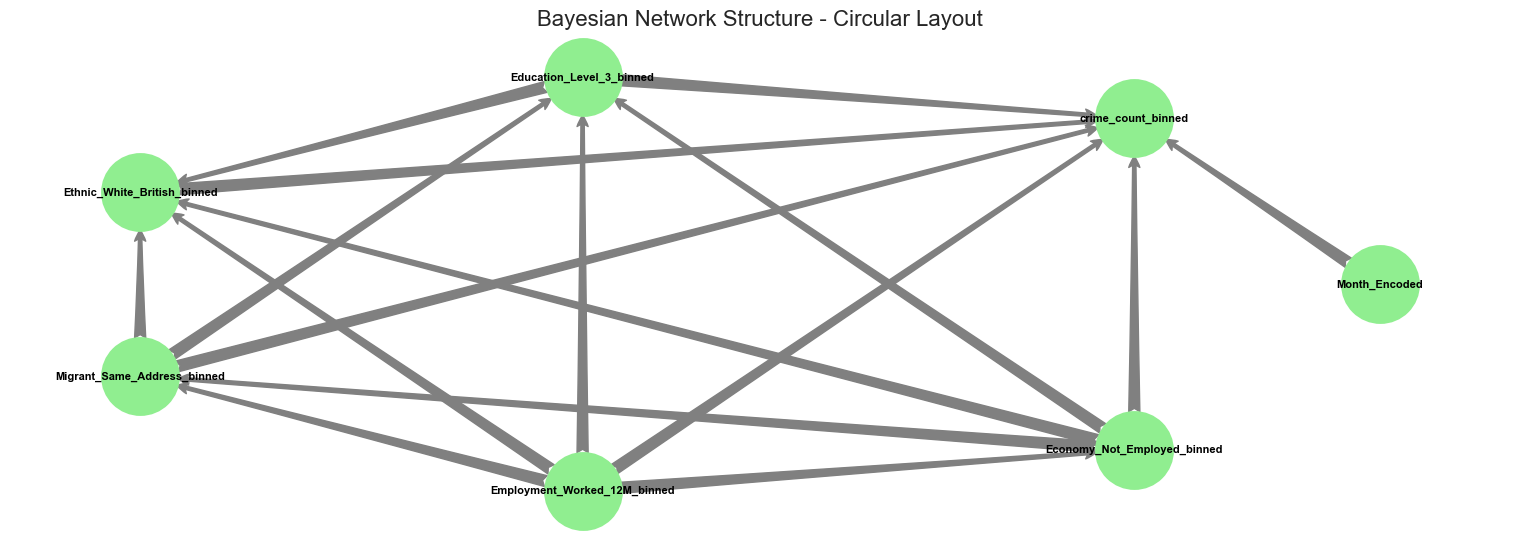

In [16]:
# Extracting the structure of the Bayesian Network
edges = model.edges()

# Create a directed graph from the Bayesian network structure
G = nx.DiGraph()
G.add_edges_from(edges)

# Set node positions using a circular layout for better organization
pos = nx.circular_layout(G)  # Circular layout for a more organized appearance

# Draw the network
plt.figure(figsize=(15, 5))  # Increase the figure size for a more spacious view
nx.draw(
    G, pos,
    with_labels=True,
    node_size=3000,  # Even larger nodes
    node_color='lightgreen',  # Softer, calming color for nodes
    font_size=8,  # Slightly larger font for labels
    font_weight='bold',
    edge_color='gray',  # Softer edge color
    linewidths=2,  # Thicker node borders for emphasis
    arrowsize=20,  # Larger arrows for better visibility
    arrowstyle='fancy',  # Different arrow style for a unique look
)

plt.title("Bayesian Network Structure - Circular Layout", fontsize=16)  # Larger title font size
plt.show()


## 16. Analysis of Variable Influence on Crime


### Analysis of Variable Influence on Crime

- **Influence Plotting**: A custom function is created to plot the influence of different variables on the probability distribution of the target variable (`crime_count_binned`). This helps in understanding how changes in one variable affect the likelihood of different crime levels.


/var/folders/nt/vmygtqvs10vb28qdjwspykv00000gn/T/ipykernel_45645/1395244980.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bayesian_data[col] = bayesian_data[col].astype('category')


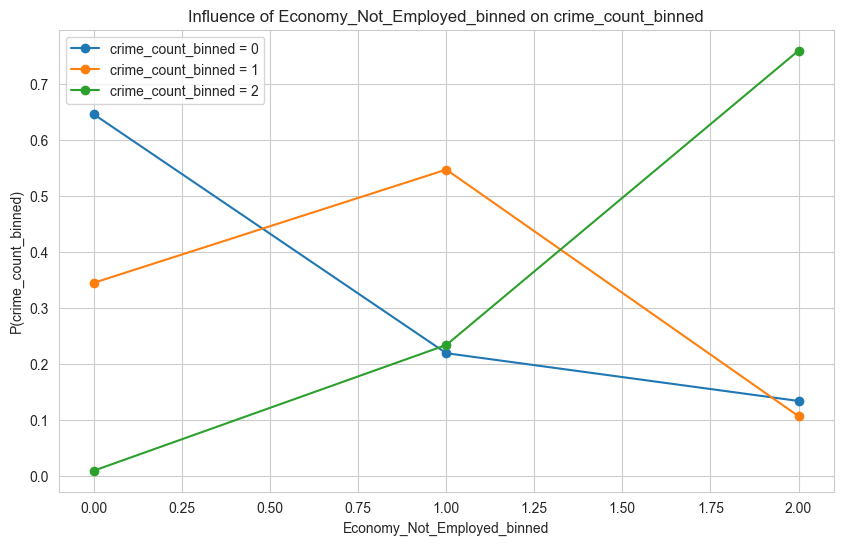

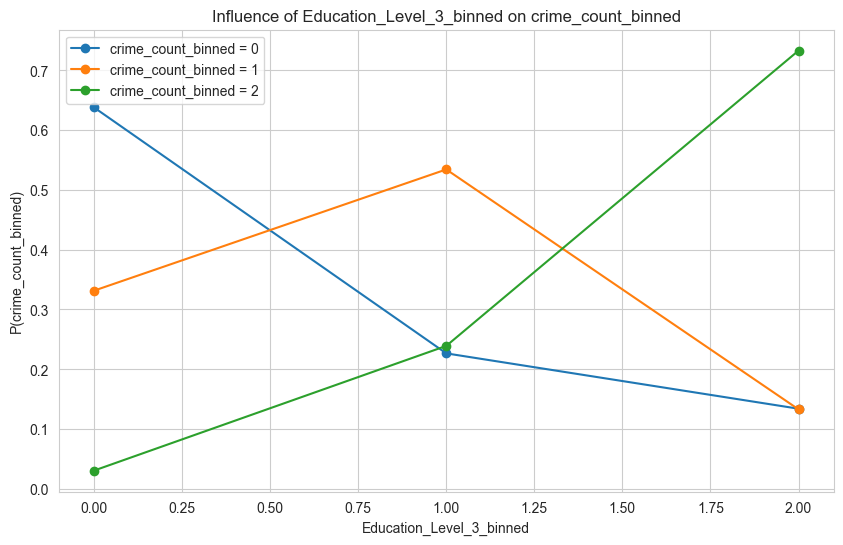

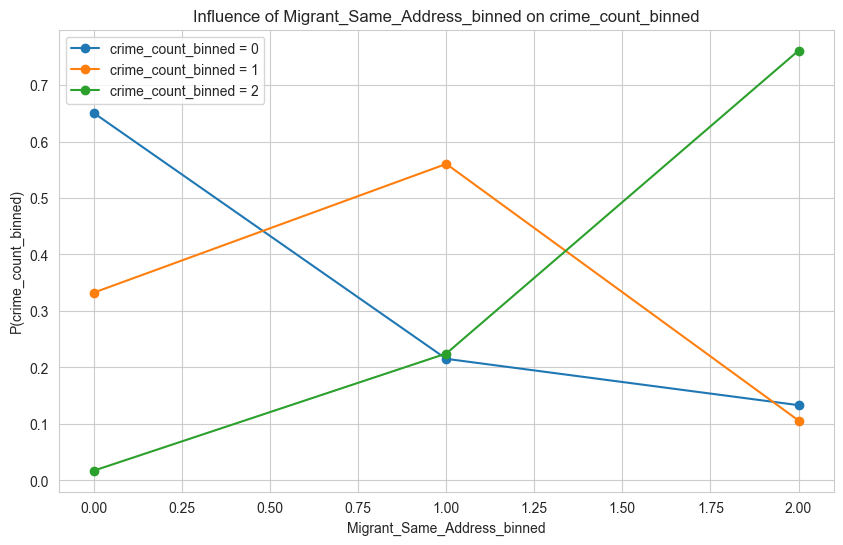

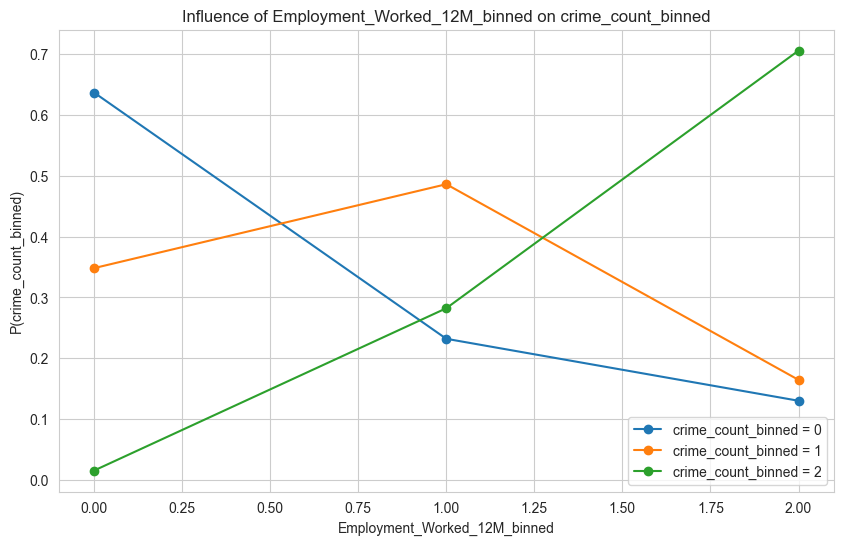

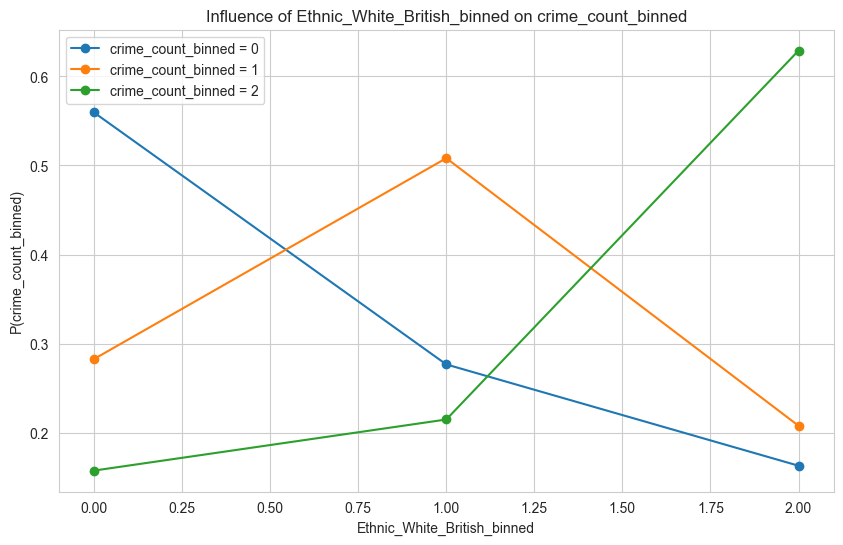

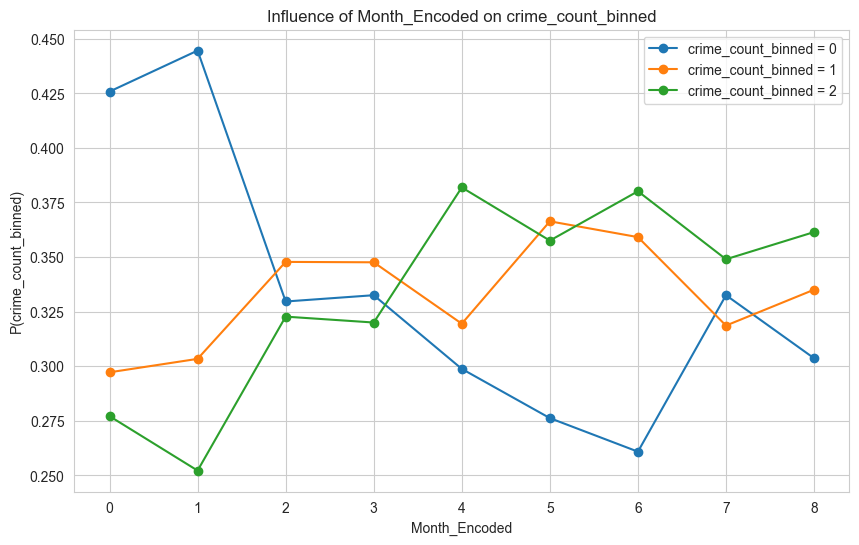

In [21]:
import matplotlib.pyplot as plt
from pgmpy.inference import VariableElimination

def plot_variable_influence(model, data, target_variable='crime_count_binned', variables_to_plot=None):
    """
    Plots the influence of different variables on the target variable's (crime_count_binned) probability distribution.
    
    :param model: The fitted Bayesian network model.
    :param data: The DataFrame used to fit the model.
    :param target_variable: The target variable to analyze (default is 'crime_count_binned').
    :param variables_to_plot: A list of variables for which to plot influence on the target variable.
    """
    if variables_to_plot is None:
        variables_to_plot = data.columns.tolist()
        variables_to_plot.remove(target_variable)

    # Initialize inference object
    inference = VariableElimination(model)

    for var in variables_to_plot:
        # Get unique values of the variable to plot
        unique_vals = sorted(data[var].unique())
        probabilities = {bin_label: [] for bin_label in data[target_variable].cat.categories}

        for val in unique_vals:
            # Query the model for the probability distribution of the target variable given the current variable's value
            query_result = inference.query(variables=[target_variable], evidence={var: val})
            for bin_label in probabilities:
                probabilities[bin_label].append(query_result.values[bin_label])

        # Plot the results
        plt.figure(figsize=(10, 6))
        for bin_label, prob_values in probabilities.items():
            plt.plot(unique_vals, prob_values, marker='o', label=f'{target_variable} = {bin_label}')

        plt.title(f'Influence of {var} on {target_variable}')
        plt.xlabel(var)
        plt.ylabel(f'P({target_variable})')
        plt.legend()
        plt.grid(True)
        plt.show()

# Ensure the relevant columns are converted to categorical dtype
categorical_columns = ['Month_Encoded', 'crime_count_binned', 'Education_Level_3_binned',
                       'Migrant_Same_Address_binned', 'Employment_Worked_12M_binned',
                       'Economy_Not_Employed_binned', 'Ethnic_White_British_binned']

# Convert each column to a categorical dtype
for col in categorical_columns:
    bayesian_data[col] = bayesian_data[col].astype('category')


plot_variable_influence(model, bayesian_data, target_variable='crime_count_binned',
                        variables_to_plot=[ 'Economy_Not_Employed_binned',
                                            'Education_Level_3_binned', 'Migrant_Same_Address_binned',
                                            'Employment_Worked_12M_binned', 'Ethnic_White_British_binned','Month_Encoded'])
